In [1]:
import pandas as pd 
import numpy as np 
import os
from distutils.dir_util import copy_tree, remove_tree
import cv2
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow import keras
from random import randint

In [2]:
default_dir = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/"
root_dir = "./"
test_dir = default_dir + "test/"
train_dir = default_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['NonDemented', 'ModerateDemented', 'MildDemented', 'VeryMildDemented']


In [3]:
CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']
IMG_SIZE = 150
IMAGE_SIZE = [150, 150]
DIM = (IMG_SIZE, IMG_SIZE)

In [4]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"
image_generator = ImageDataGenerator(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, 
                                     data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

In [5]:
train_dataset = image_generator.flow_from_directory(batch_size=6500,
                                                    directory=work_dir,
                                                    target_size=(150, 150),
                                                    shuffle= True)


Found 6400 images belonging to 4 classes.


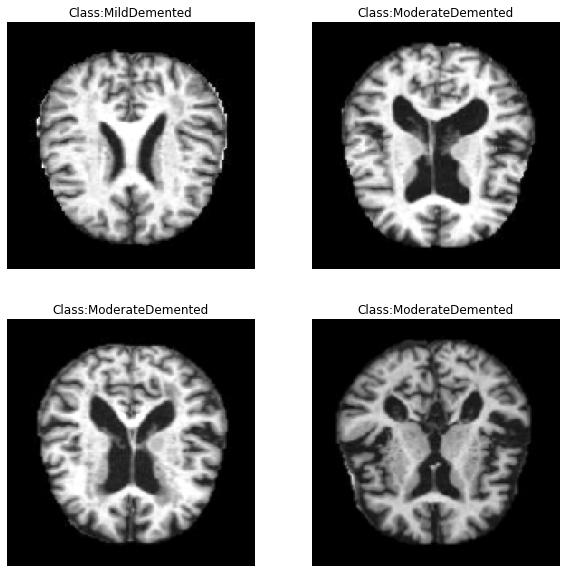

In [6]:
def show_images(generator,y_pred=None):
  
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a lot of images
    x,y = generator.next()
    
    # show a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(4):
            ax = plt.subplot(2, 2, i + 1)
            idx = randint(0,50)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(4):
            ax = plt.subplot(2, 2, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_dataset)

<BarContainer object of 4 artists>

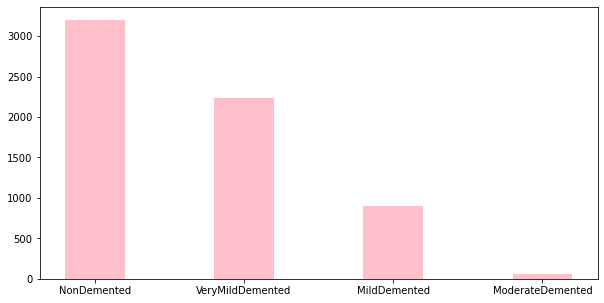

In [7]:
data = {'NonDemented':      0, 
        'VeryMildDemented': 0, 
        'MildDemented':     0,
        'ModerateDemented': 0}

# visualizing dataset
for cls in os.listdir(work_dir):
    for img in os.listdir(work_dir + '/' + cls):
        data[cls] = data[cls] + 1
        
keys = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
plt.bar(keys, values, color='pink', width = 0.4)

In [8]:
train_data, train_labels = train_dataset.next()

In [9]:
print(train_labels)

[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


In [10]:
numerical_labels = np.argmax(train_labels, axis=1)


In [11]:
print(numerical_labels)

[3 2 3 ... 2 3 2]


In [12]:
for i in range(len(numerical_labels)):
    if numerical_labels[i] == 0:
        numerical_labels[i] = 0
    else:
        numerical_labels[i] = 1


In [13]:
print(numerical_labels)

[1 1 1 ... 1 1 1]


In [14]:
print(train_data.shape, numerical_labels.shape)

(6400, 150, 150, 3) (6400,)


In [15]:
#resampling data

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), numerical_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(11008, 150, 150, 3) (11008,)


In [16]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

# Training models

In [17]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from keras.models import Model

# Create the model
input_img = Input(shape=(150, 150, 3))
encoder = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
encoder = MaxPooling2D(pool_size=(2, 2))(encoder)
encoder = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder)
encoder = MaxPooling2D(pool_size=(2, 2))(encoder)
encoder = Flatten()(encoder)
encoder = Dense(150, activation='relu')(encoder)
encoder = Dense(1, activation='sigmoid')(encoder)
# Compile the model
model = Model(input_img, encoder)

# Fit the model to the training data

2023-02-09 14:27:20.421166: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-09 14:27:20.515030: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-09 14:27:20.515821: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-09 14:27:20.517067: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [18]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=10,
                                            restore_best_weights=True)

In [19]:
model.compile(optimizer='adam',
loss='binary_crossentropy',
metrics=['accuracy'])

In [20]:
result = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=100)

2023-02-09 14:27:23.190603: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1901880000 exceeds 10% of free system memory.
2023-02-09 14:27:25.409832: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1901880000 exceeds 10% of free system memory.
2023-02-09 14:27:26.935998: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2023-02-09 14:27:28.257565: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


221/221 [==============================] - 11s 19ms/step - loss: 0.5837 - accuracy: 0.6658 - val_loss: 0.3840 - val_accuracy: 0.8235
Epoch 2/100
221/221 [==============================] - 3s 15ms/step - loss: 0.3180 - accuracy: 0.8634 - val_loss: 0.2603 - val_accuracy: 0.8973
Epoch 3/100
221/221 [==============================] - 3s 13ms/step - loss: 0.1829 - accuracy: 0.9287 - val_loss: 0.1417 - val_accuracy: 0.9535
Epoch 4/100
221/221 [==============================] - 3s 14ms/step - loss: 0.0964 - accuracy: 0.9668 - val_loss: 0.0941 - val_accuracy: 0.9659
Epoch 5/100
221/221 [==============================] - 3s 13ms/step - loss: 0.0507 - accuracy: 0.9832 - val_loss: 0.0884 - val_accuracy: 0.9648
Epoch 6/100
221/221 [==============================] - 3s 13ms/step - loss: 0.0363 - accuracy: 0.9876 - val_loss: 0.1794 - val_accuracy: 0.9319
Epoch 7/100
221/221 [==============================] - 3s 13ms/step - loss: 0.0213 - accuracy: 0.9933 - val_loss: 0.0514 - val_accuracy: 0.9796
Epo

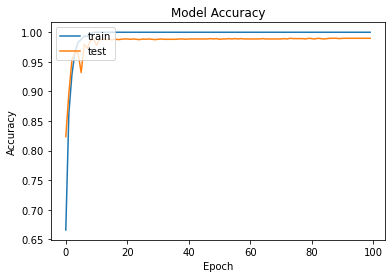

In [21]:
# dictionary keys seems to have changed in version 2
k = ''
if 'accuracy' in result.history :
    k = 'accuracy'    

if 'acc' in result.history :
    k = 'acc'
    
if k != '' :    
    plt.plot(result.history[k])
    plt.plot(result.history['val_'+k])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

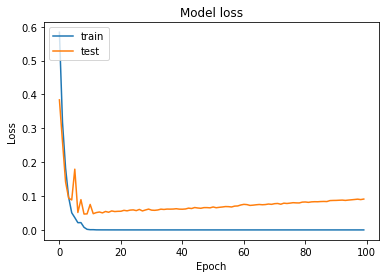

In [22]:
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
model.save('zheimer.h5')

In [24]:
loss, accuracy = model.evaluate(test_data, test_labels)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

2023-02-09 14:32:53.641078: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 594540000 exceeds 10% of free system memory.
2023-02-09 14:32:54.383407: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 594540000 exceeds 10% of free system memory.


69/69 [==============================] - 1s 7ms/step - loss: 0.1255 - accuracy: 0.9864
Loss:  0.1255057454109192
Accuracy:  0.9863760471343994


In [25]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 43808)             0         
_________________________________________________________________
dense (Dense)                (None, 150)               657135

In [26]:
#learning rate
def lr(model):
# Get the optimizer object from the model
  optimizer = model.optimizer
# Get the learning rate from the optimizer
  learning_rate = optimizer.lr.numpy()
  print("Learning Rate:", learning_rate)
  return learning_rate

In [27]:
lr1=lr(model)

Learning Rate: 0.001


In [28]:
def drop_out(model):
# Iterate over the layers in the model
  for i, layer in enumerate(model.layers):
    if isinstance(layer, tf.keras.layers.Dropout):
        dropout_rate = layer.rate
        print("Dropout Layer #{}: rate={}".format(i, dropout_rate))
        return dropout_rate


In [29]:
do=drop_out(model)
print(do)

None


In [30]:
def attlayers(model):
# Get the number of hidden attentions
 attention_layers = [layer for layer in model.layers if isinstance(layer, keras.layers.Attention)]
 num_hidden_attentions = len(attention_layers)

 print("Number of hidden attentions:", num_hidden_attentions)
 return num_hidden_attentions

In [31]:
attlayer=attlayers(model)

Number of hidden attentions: 0


In [32]:
def hidunit(model):
# Get the number of hidden units
 num_hidden_units = 0
 for layer in model.layers:
    if hasattr(layer, "units"):
        num_hidden_units += layer.units

 print("Number of hidden units:", num_hidden_units)
 return num_hidden_units


In [33]:
hiddenunit=hidunit(model)

Number of hidden units: 151


In [34]:
def conv(model):
# Get the number of Conv2D layers
 conv2d_layers = [layer for layer in model.layers if isinstance(layer, keras.layers.Conv2D)]
 num_conv2d_layers = len(conv2d_layers)
 print("Number of Conv2D layers:", num_conv2d_layers)
 return num_conv2d_layers


In [35]:
convl=conv(model)

Number of Conv2D layers: 2


In [36]:
def conv3(model):

# Get the number of Conv3D layers
 conv3d_layers = [layer for layer in model.layers if isinstance(layer, keras.layers.Conv3D)]
 num_conv3d = len(conv3d_layers)
 print("Number of Conv3D layers:", num_conv3d)
 return num_conv3d


In [37]:
conv3l=conv3(model)

Number of Conv3D layers: 0


In [38]:
def dense(model):
# Get the number of dense layers
 dense_layers = [layer for layer in model.layers if isinstance(layer, keras.layers.Dense)]
 num_dense_layers = len(dense_layers)
 print("Number of dense layers:", num_dense_layers)
 return num_dense_layers


In [39]:
denslayr=dense(model)

Number of dense layers: 2


In [40]:
def upsamling(model):

# Get the number of up-sampling layers
 upsampling_layers = [layer for layer in model.layers if isinstance(layer, keras.layers.UpSampling2D)]
 num_upsampling_layers = len(upsampling_layers)
 print("Number of up-sampling layers:", num_upsampling_layers)
 return num_upsampling_layers

In [41]:
uplay=upsamling(model)

Number of up-sampling layers: 0


In [42]:
def maxpooling(model):
# Get the number of up-sampling layers
 MaxPooling2D_layers = [layer for layer in model.layers if isinstance(layer, keras.layers.MaxPooling2D)]
 num_MaxPooling2D_layers = len(MaxPooling2D_layers)
 print("Number of MaxPooling2D layers:", num_MaxPooling2D_layers)
 return num_MaxPooling2D_layers

In [43]:
maxlay=maxpooling(model)

Number of MaxPooling2D layers: 2


In [44]:
def patch(model):

# Get the patch size
 patch_size = 0
 for layer in model.layers:
    if isinstance(layer, keras.layers.Conv2D):
        patch_size = layer.kernel_size[0]
        break

 print("Patch size:", patch_size)
 return patch_size

In [45]:
p=patch(model)

Patch size: 3


In [46]:

# Retrieve the optimizer
optimizer = model.optimizer
print("Optimizer used:", optimizer)


Optimizer used: <keras.optimizer_v2.adam.Adam object at 0x7fade6fe41d0>


In [47]:
y_pred=model.predict(test_data)
print(y_pred)
for i in range(len(y_pred)):
    if y_pred[i] >= .5:
        y_pred[i] = 1
    else:
        y_pred[i] = 0

        

2023-02-09 14:33:10.484667: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 594540000 exceeds 10% of free system memory.


[[1.000000e+00]
 [1.000000e+00]
 [9.546732e-15]
 ...
 [1.000000e+00]
 [1.563442e-19]
 [8.082100e-14]]


In [48]:

y_pred=np.array(y_pred).flatten().astype(int)
print(y_pred)

[1 1 0 ... 1 0 0]


In [49]:
print(y_pred)
print(test_labels)

[1 1 0 ... 1 0 0]
[1 1 0 ... 1 0 0]


In [50]:
# Print the confusion matrix using Matplotlib
def cm(y_test, y_pred,name):
 title="confusion matrix of "+ name
 conf_matrix = confusion_matrix(y_test, y_pred)
 fig, ax = plt.subplots(figsize=(5, 5))
 ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
 for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 plt.xlabel('Predictions', fontsize=18)
 plt.ylabel('Actuals', fontsize=18)
 plt.title(title, fontsize=18)
 plt.show()

In [51]:
print(test_labels)
print(y_pred)

[1 1 0 ... 1 0 0]
[1 1 0 ... 1 0 0]


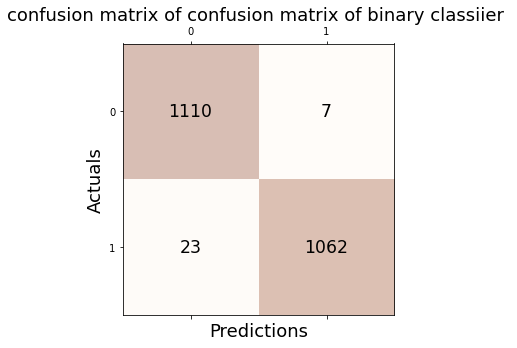

In [52]:
import numpy as np
from sklearn.metrics import confusion_matrix
# Calculate the confusion matrix
x=cm(test_labels, y_pred,"confusion matrix of binary classiier ")

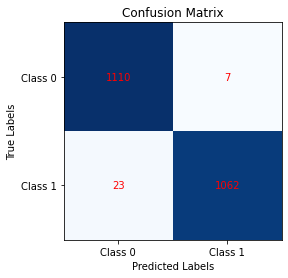

In [53]:

# Compute the confusion matrix
cm = confusion_matrix(test_labels, y_pred)

# Plot the confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks([0, 1], ["Class 0", "Class 1"])
plt.yticks([0, 1], ["Class 0", "Class 1"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="red")
plt.show()

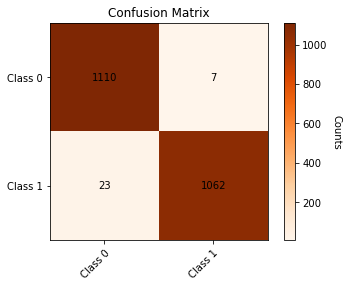

In [54]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(test_labels, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Oranges')

# Add labels to the plot
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Class 0', 'Class 1'])
ax.set_yticklabels(['Class 0', 'Class 1'])

# Rotate the x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add a colorbar to the plot
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Counts", rotation=-90, va="bottom")

# Loop over data dimensions and create text annotations
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

# Set the title of the plot
ax.set_title("Confusion Matrix")

# Show the plot
plt.show()


In [55]:

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
score=accuracy_score(test_labels, y_pred)*100
print('Accuracy : \n{0}'.format(score))
conf_mx = confusion_matrix(test_labels, y_pred)
print('Confusion matrix of testing: \n{0}'.format(conf_mx))
print(classification_report(test_labels, y_pred))


Accuracy : 
98.63760217983652
Confusion matrix of testing: 
[[1110    7]
 [  23 1062]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1117
           1       0.99      0.98      0.99      1085

    accuracy                           0.99      2202
   macro avg       0.99      0.99      0.99      2202
weighted avg       0.99      0.99      0.99      2202

